## Reading dataset and Images

In [1]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import load_img, img_to_array, array_to_img

In [2]:
import os
if os.path.exists('/content/imageProcessing') == False:
  !git clone https://github.com/amrik220/imageProcessing

Cloning into 'imageProcessing'...
remote: Enumerating objects: 9091, done.
remote: Total 9091 (delta 0), reused 0 (delta 0), pack-reused 9091
Receiving objects: 100% (9091/9091), 65.15 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [3]:
# load data labels from the csv file
# data = pd.read_csv('./emergency_class_labels.csv')
data = pd.read_csv('/content/imageProcessing/classify_as_emergency_vehicle/emergency_class_labels.csv')

data.head()
data.shape

(2352, 2)

In [4]:
# check class balance
data.emergency_or_not.value_counts()
data.emergency_or_not.value_counts()[1]/data.emergency_or_not.value_counts()[0]*100

72.81410727406319

In [5]:
# load images and store it in a numpy array
x = []
for img_name in data.image_names:
    # img = plt.imread('./images/' + img_name)
    img = plt.imread('/content/imageProcessing/classify_as_emergency_vehicle/images/' + img_name)

    x.append(img)
    
x = np.array(x)

# create target
y = data.emergency_or_not.values

x.ndim, x.shape

(4, (2352, 224, 224, 3))

In [6]:
# preprocessing
x_min = x.min()
x_max = x.max()
x = (x - x_min) / (x_max - x_min)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Split into Train and Test set
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=220)

## Perform Image Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
datagen = ImageDataGenerator(
    width_shift_range = 0.2,
    horizontal_flip = True
)


## Build model

In [11]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout

In [12]:
model = Sequential([
 InputLayer(input_shape=(224, 224, 3)),

 Convolution2D(32, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),

 Convolution2D(64, (5, 5), activation='relu', padding='same'),
 Convolution2D(64, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),

 Convolution2D(128, (5, 5), activation='relu', padding='same'),
 Convolution2D(128, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),
    
 Convolution2D(256, (5, 5), activation='relu', padding='same'),
 Convolution2D(256, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),
    
 Convolution2D(512, (5, 5), activation='relu', padding='same'),
 Convolution2D(512, (5, 5), activation='relu', padding='same'),

 GlobalAveragePooling2D(),
 BatchNormalization(),

 Dense(units=512, activation='sigmoid'),
 BatchNormalization(),
 Dropout(0.5),
    
 Dense(units=256, activation='sigmoid'),
 BatchNormalization(),
 Dropout(0.5),
    
 Dense(units=1, activation='sigmoid'),
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

In [14]:
from keras.optimizers import SGD

In [15]:
sgd = SGD(nesterov=True)

In [16]:
import keras.backend as K
import tensorflow as tf

In [17]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = 1e-12
        y_pred=K.clip(y_pred,eps,1.-eps)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [18]:
focal_loss = focal_loss()

In [19]:
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
final_weights_path = 'best_cnn_model.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=2, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=20, verbose=2)
]

In [22]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),
                              epochs=5, validation_data=(x_test, y_test), callbacks=callbacks_list, shuffle=False, workers=5, use_multiprocessing=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 0.8139 - accuracy: 0.6488 
Epoch 00001: val_loss improved from inf to 0.68739, saving model to best_cnn_model.h5
33/33 [==============================] - 1823s 55s/step - loss: 0.8139 - accuracy: 0.6488 - val_loss: 0.6874 - val_accuracy: 0.6091
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6981 
Epoch 00002: val_loss improved from 0.68739 to 0.67685, saving model to best_cnn_model.h5
33/33 [==============================] - 1829s 55s/step - loss: 0.6674 - accuracy: 0.6981 - val_loss: 0.6769 - val_accuracy: 0.6091
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7606 
Epoch 00003: val_loss improved from 0.67685 to 0.67319, saving model to best_cnn_model.h5
33/33 [==============================] - 1830s 55s/step - loss: 0.5367 - accuracy: 0.7606 - val_loss: 0.6732 - v

In [23]:
import matplotlib.pyplot as plt

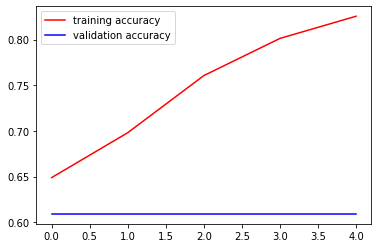

In [24]:
# Plotting training accuracy vs validation accuracy

plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend({'training accuracy': 'r', 'validation accuracy':'b'})
plt.show()

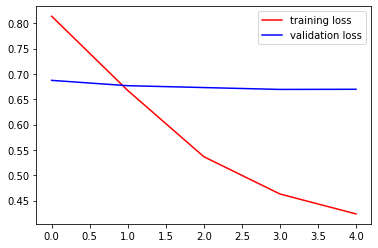

In [25]:
# Plotting training loss vs validation loss

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'training loss': 'r', 'validation loss':'b'})
plt.show()